In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

C:\Users\Owner\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the Medicaid Enrollment Data
# Assuming the dataset has a similar structure and includes Medicare enrollment data
df = pd.read_csv('Medicaid_data.csv', encoding='unicode_escape')

In [3]:
# Filter rows that are the final report only and exclude a specific problematic date
# This ensures we're working with complete and relevant data
df = df[df['final_report'] == 'Y']
df = df[df['report_date'] != '09/01/2013']

In [4]:
# Remove rows with missing Medicare enrollment numbers, if the column name for Medicare is different, adjust 'total_medicaid_enrollment' accordingly
df.dropna(subset=['total_medicaid_enrollment'], inplace=True)

In [5]:
# Convert 'report_date' to datetime to enable time-based operations
df['report_date'] = pd.to_datetime(df['report_date'])

In [6]:
# Filter the data for New Jersey (NJ) to focus on Medicare enrollment in this state
nj_df = df[df['state_abbreviation'] == 'NJ']

In [7]:
# Create a monthly period column from 'report_date' for monthly aggregation
nj_df['month'] = nj_df['report_date'].dt.to_period('M')

C:\Users\Owner\AppData\Local\Temp\ipykernel_23384\3281621256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nj_df['month'] = nj_df['report_date'].dt.to_period('M')


In [8]:
# Aggregate NJ Medicaid data monthly
# Summing up Medicaid enrollment for each month to prepare the data for forecasting
monthly_nj_medicaid = nj_df.groupby('month').agg(total_medicaid_enrollment=('total_medicaid_enrollment', 'sum')).reset_index()

In [9]:
# Prepare the aggregated data for forecasting with Prophet
# Prophet requires a 'ds' column for dates and a 'y' column for the target variable we wish to forecast
monthly_nj_medicaid['ds'] = monthly_nj_medicaid['month'].dt.to_timestamp()
monthly_nj_medicaid['y'] = monthly_nj_medicaid['total_medicaid_enrollment']

In [10]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(monthly_nj_medicaid[['ds', 'y']])

13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a dataframe for future predictions
# Here, we're specifying to forecast 12 months into the future on a monthly frequency
future = model.make_future_dataframe(periods=120, freq='M')

C:\Users\Owner\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [19]:
# Use the model to predict future Medicaid enrollment in NJ
forecast = model.predict(future)

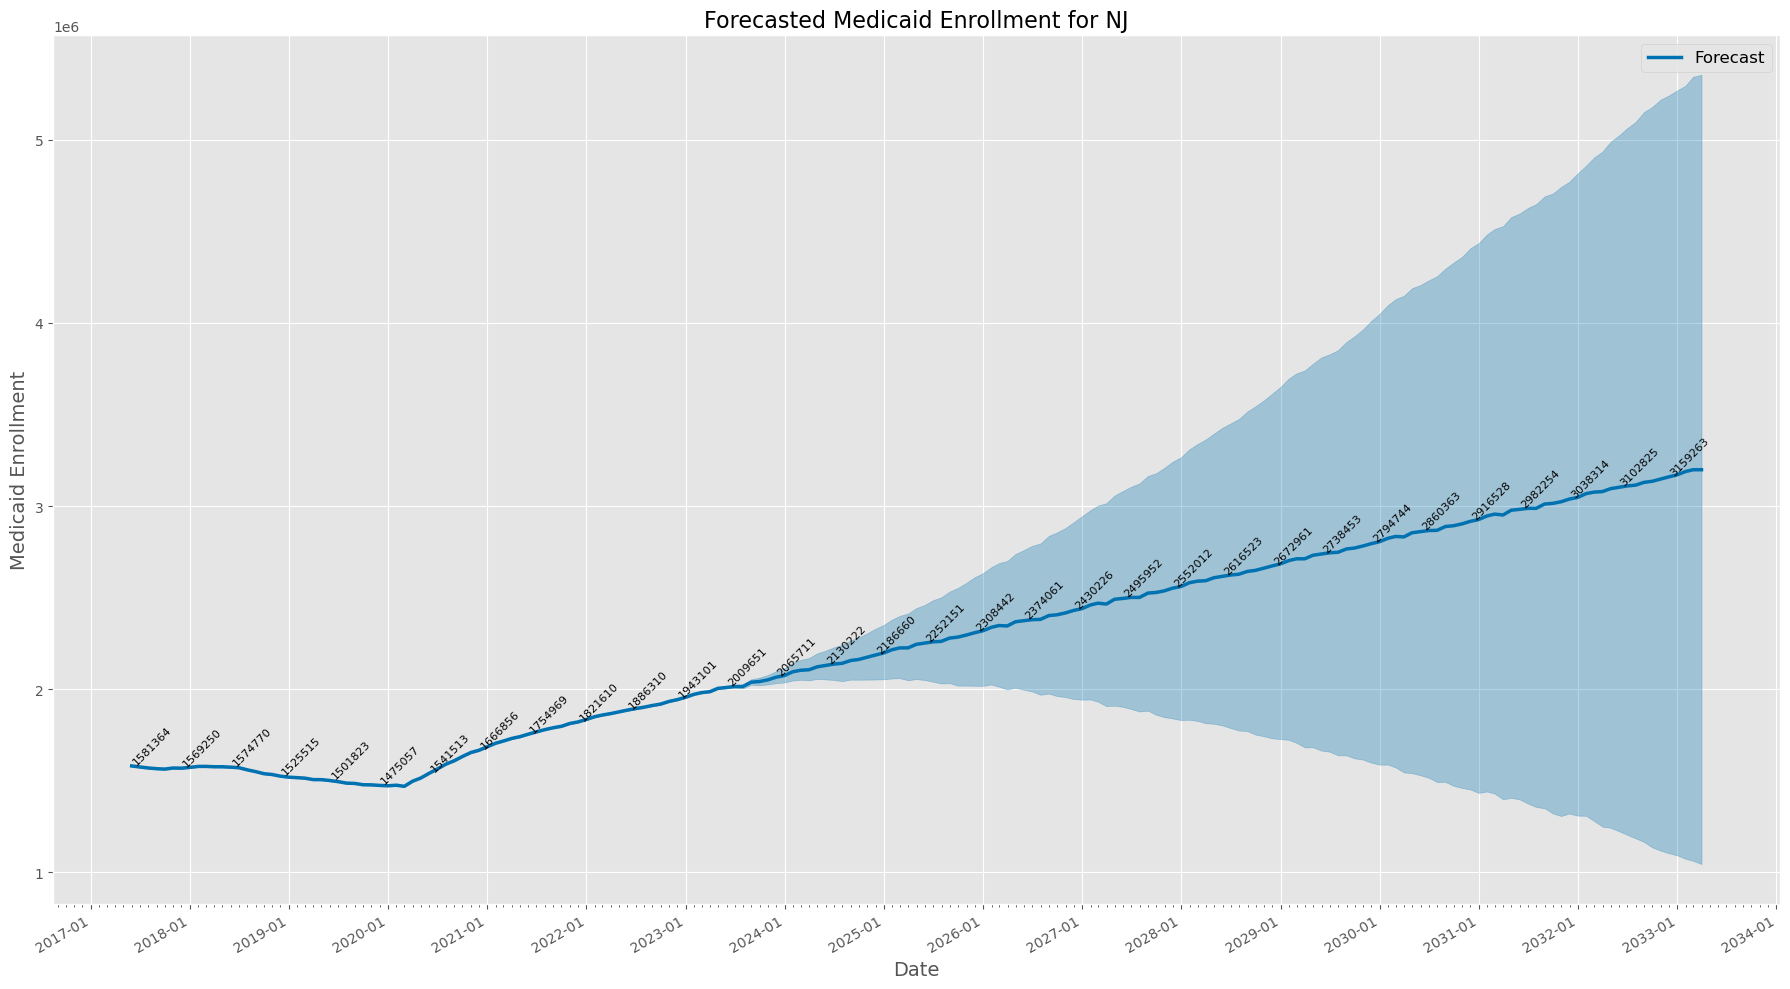

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set a style for the plot to make it more visually appealing
plt.style.use('ggplot')

# Create the plot with increased figure size for better visibility
plt.figure(figsize=(18, 10))

# Plot the forecast results with a line plot for predicted values and a shaded area for uncertainty
plt.plot(forecast['ds'], forecast['yhat'], '-', label='Forecast', color='#0072B2', linewidth=2.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.3)

# Set major and minor ticks format on the x-axis to display dates more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() # Rotation

# Add labels to the plot for clarity
plt.xlabel('Date', fontsize=14)
plt.ylabel('Medicaid Enrollment', fontsize=14)
plt.title('Forecasted Medicaid Enrollment for NJ', fontsize=16)
plt.legend(fontsize=12)

# Add data labels to the forecasted points for better readability
# Here, we add labels to every 6th month to avoid cluttering the plot
for i, (date, value) in enumerate(zip(forecast['ds'], forecast['yhat'])):
    if i % 6 == 0:  # Adjust this value as needed to reduce/increase label frequency
        plt.text(date, value, f'{value:.0f}', ha='left', va='bottom', fontsize=8, rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
# Keep only the last ten years of data
# Assuming 'report_date' is in datetime format after conversion
nj_df_last_5_years = nj_df[nj_df['report_date'] >= (pd.Timestamp.now() - pd.DateOffset(years=5))]

In [23]:
# Combine the historical data with the forecasted data
# Note: We need to adjust the historical data to match the forecasted data format
historical_data_for_export = monthly_nj_medicaid[['ds', 'y']].rename(columns={'y': 'yhat'})
combined_data = pd.concat([historical_data_for_export, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]])

In [24]:
# Export the combined dataset to a new CSV file
combined_data.to_csv('NJ_Medicaid_Enrollment_Forecast.csv', index=False)